## This notebook is a prototype of our main project. 

## It use the ecg-id-database-1.0.0 data from Physionet to test algorithms that used to filter the ECG waves and use feature extraction algorithms to extract 20 features from these waves and use them to train the Machine Learning models.  

In [123]:
# DataFrame packages
import numpy as np
import pandas as pd

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# heart packages
import wfdb
import heartpy
import systole
import neurokit2 as nk
import pyhrv.tools as tools
import pyhrv.time_domain as td
import pyhrv

# ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score

# others
import os
import joblib

# Physionet

In [125]:
# using wfdb, get physionet signals
signal, sig_features = wfdb.io.rdsamp('D:\\University\\Graduation Project Materials and Models\\ecg-id-database-1.0.0\\Person_01\\rec_16')

# Data Preprocessing

In [126]:
# get the second signal and the sampling rate(fs) and pass it to neatkit to get the required features from signal
signals, info = nk.ecg_process(signal[:, 1], sampling_rate=sig_features['fs'])

In [127]:
# get the main signal features using ecg_delineate
sigs, features = nk.ecg_delineate(signals, sampling_rate=sig_features['fs'])

In [128]:
# create our dataframe to store the data
Extracted_Features_DF = pd.DataFrame(columns=[
    'PR Distances', 'PR Slope', 'PR Amplitude',
    'PQ Distances', 'PQ Slope', 'PQ Amplitude',
    'QS Distances', 'QS Slope', 'QS Amplitude',
    'ST Distances', 'ST Slope', 'ST Amplitude',
    'RT Distances', 'RT Slope', 'RT Amplitude',

    'PS Amplitude', 'PT Amplitude', 'TQ Amplitude',
    'QR Amplitude', 'RS Amplitude'
])

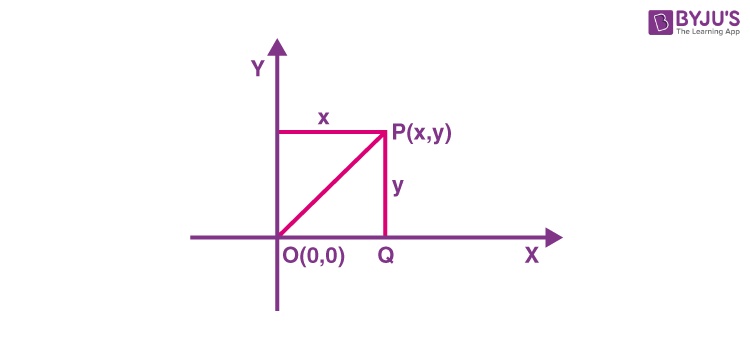

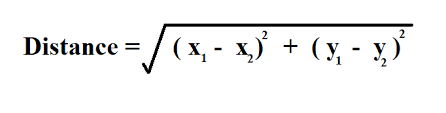

In [129]:
'''
    this function  takes four parameters point1: (X1, Y1)(an ECG peak), point2: (X2, Y2)(an ECG peak) 
    to get the distances between ecg peaks, and return the distance between these two peaks.
    {PR Distances, PQ Distances, QS Distances, ST Distances, RT Distances}
'''

def Distances(X1, Y1, X2, Y2):
    distances_results = []
    
    for x1, y1, x2, y2 in zip(X1, Y1, X2, Y2):
        result = np.math.sqrt((x2 - x1)**2 + (y2-y1)**2)
        distances_results.append(result)
        
    return distances_results

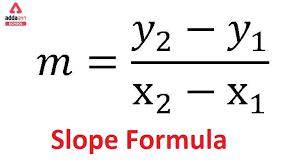

In [130]:
'''
    this function takes four parameters point1: (X1, Y1)(an ECG peak), point2: (X2, Y2)(an ECG peak) 
    to get the slope of the lines between ecg peaks, and return the slope between these two peaks.
    {PR Slope, PQ Slope, QS Slope, ST Slope, RT Slope}
'''

def Slope(X1, Y1, X2, Y2):
    slope_results = []
    
    for x1, y1, x2, y2 in zip(X1, Y1, X2, Y2):
        result = (y2 - y1) / (x2 - x1)
        slope_results.append(result)
        
    return slope_results

In [131]:
'''
    this function takes two ECG peaks and gets the amplitudes between ecg peaks from the dataframe that we've created.
    and return the total amplitude between these two waves.
    {PR Amplitude, PQ Amplitude, QS Amplitude, ST Amplitude
    , RT Amplitude, PS Amplitude, PT Amplitude, TQ Amplitude
    ,QR Amplitude, RS Amplitude}
'''

def Amplitudes(column1, column2):
    
    # remove nulls from ECG signal
    new_features_col1, new_features_col2 = remove_nulls(column1, column2)
    
    if column1 == 'ECG_R_Peaks':
        Amp1 = signals.iloc[new_features_col1.values.flatten(), 1]
    else:
        Amp1 = signals.iloc[new_features_col1.values.flatten(), 1]
        
    if column2 == 'ECG_R_Peaks':
        Amp2 = signals.iloc[new_features_col2.values.flatten(), 1]
    else:
        Amp2 = signals.iloc[new_features_col2.values.flatten(), 1]
        
    amplitudes = np.abs(Amp1.values - Amp2.values)
    
    return amplitudes

In [132]:
'''
    this function takes two ECG peaks with nulls and removes the nulls from the ECG wave,
    and return the correct two ECG peaks.
'''

def remove_nulls(column1, column2):
    
    if column1 == 'ECG_R_Peaks' and column2 != 'ECG_R_Peaks':
        
        # change the NULL values with true and false, where true means it's a null value.
        # to show only the indices of nulls.
        
        TF_selection = pd.DataFrame(np.array(features[column2])).notna().values.flatten()
        new_features_col2 = pd.DataFrame(np.array(features[column2])).dropna()
        new_features_col1 = pd.DataFrame(np.array(info[column1])[TF_selection])
    
    
    if column1 != 'ECG_R_Peaks' and column2 == 'ECG_R_Peaks':
        TF_selection = pd.DataFrame(np.array(features[column1])).notna().values.flatten()
        new_features_col1 = pd.DataFrame(np.array(features[column1])).dropna()
        new_features_col2 = pd.DataFrame(np.array(info[column2])[TF_selection])
    
    
    if column1 != 'ECG_R_Peaks' and column2 != 'ECG_R_Peaks':
        TF_selection = pd.DataFrame(np.array(features[column1])).notna().values.flatten()
        new_features_col1 = pd.DataFrame(np.array(features[column1])).dropna()
        new_features_col2 = pd.DataFrame(np.array(features[column2])[TF_selection])
        
        TF_selection = new_features_col2.notna().values.flatten()
        new_features_col2 = new_features_col2.dropna()
        new_features_col1 = pd.DataFrame(np.array(new_features_col1.values.flatten())[TF_selection])
        
    return new_features_col1, new_features_col2

# Features Extraction

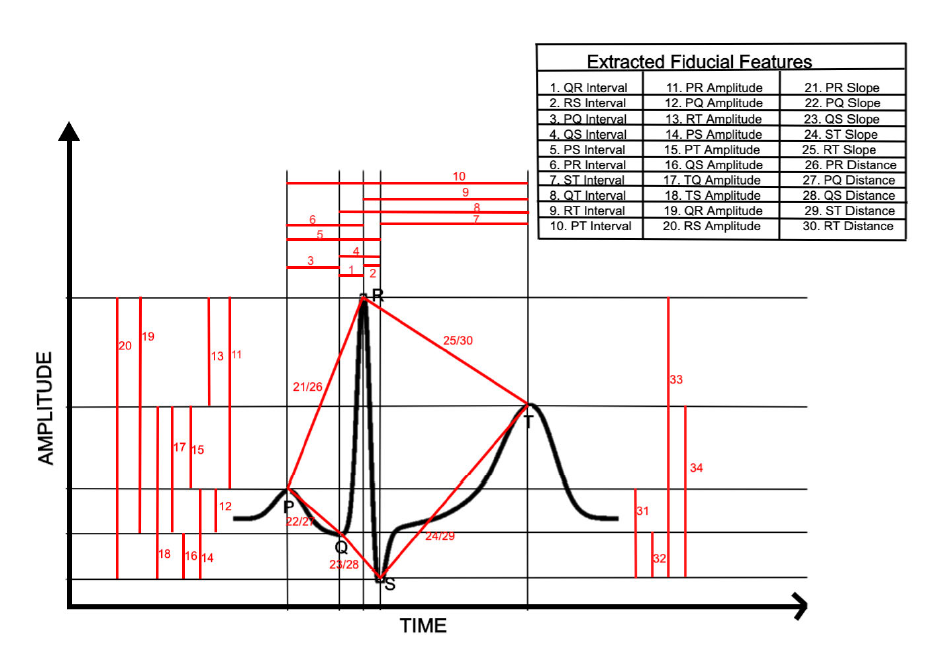

In [133]:
'''
    this function takes two ECG peaks, and return the distances, slopes and amplitudes between peaks.
'''

def get_ECG_features(column1, column2):
    
    if column1 == 'ECG_R_Peaks':
        X1 = info[column1]
        Y1 = signals.iloc[info[column1], 1]
    else:
        new_features = pd.DataFrame(np.array(features[column1])).dropna()
        flatten_new_features = new_features.values.flatten()

        X1 = flatten_new_features.astype('int')
        Y1 = signals.iloc[flatten_new_features.astype('int'), 1]
    
    if column2 == 'ECG_R_Peaks':
        X2 = info[column2]
        Y2 = signals.iloc[info[column2], 1]
    else:
        new_features = pd.DataFrame(np.array(features[column2])).dropna()
        flatten_new_features = new_features.values.flatten()

        X2 = flatten_new_features.astype('int')
        Y2 = signals.iloc[flatten_new_features.astype('int'), 1]
        
    # Calculate Distances
    distances = Distances(X1, Y1, X2, Y2)
    
    # Calculate Slope
    slopes = Slope(X1, Y1, X2, Y2)
    
    # Calculate Amplitude
    amplitudes = Amplitudes(column1, column2)

    return distances, slopes, amplitudes


In [134]:
'''
    this function takes two ECG Offset and Onset, and return the segments between peaks.
'''
def wave_segments(offsets_column, onsets_column):
    Offsets = pd.DataFrame(features)[offsets_column]
    Onsets = pd.DataFrame(features)[onsets_column]
    
    segment = Offsets - Onsets
    return segment

In [135]:
# Features between PR
PR_distances, PR_slopes, PR_amplitudes = get_ECG_features('ECG_R_Peaks', 'ECG_P_Peaks')

In [136]:
# Features between PQ
PQ_distances, PQ_slopes, PQ_amplitudes = get_ECG_features('ECG_Q_Peaks', 'ECG_P_Peaks')

In [137]:
# Features between QS
QS_distances, QS_slopes, QS_amplitudes = get_ECG_features('ECG_Q_Peaks', 'ECG_S_Peaks')

In [138]:
# Features between RT
RT_distances, RT_slopes, RT_amplitudes = get_ECG_features('ECG_R_Peaks', 'ECG_T_Peaks')

In [139]:
# Features between ST
ST_distances, ST_slopes, ST_amplitudes = get_ECG_features('ECG_S_Peaks', 'ECG_T_Peaks')

In [140]:
# Amplitudes
PS_amplitudes = Amplitudes('ECG_S_Peaks', 'ECG_P_Peaks')
PT_amplitudes = Amplitudes('ECG_T_Peaks', 'ECG_P_Peaks')
TQ_amplitudes = Amplitudes('ECG_T_Peaks', 'ECG_Q_Peaks')
RQ_amplitudes = Amplitudes('ECG_Q_Peaks', 'ECG_R_Peaks')
RS_amplitudes = Amplitudes('ECG_R_Peaks', 'ECG_S_Peaks')

In [142]:
Extracted_Features_DF['PR Distances'] = PR_distances
Extracted_Features_DF['PR Slope'] = PR_slopes
Extracted_Features_DF['PR Amplitude'] = PR_amplitudes

Extracted_Features_DF['PQ Distances'] = PQ_distances
Extracted_Features_DF['PQ Slope'] = PQ_slopes
Extracted_Features_DF['PQ Amplitude'] = PQ_amplitudes

Extracted_Features_DF['QS Distances'] = QS_distances
Extracted_Features_DF['QS Slope'] = QS_slopes
Extracted_Features_DF['QS Amplitude'] = QS_amplitudes

Extracted_Features_DF['ST Distances'] = ST_distances
Extracted_Features_DF['ST Slope'] = ST_slopes
Extracted_Features_DF['ST Amplitude'] = ST_amplitudes

Extracted_Features_DF['RT Distances'] = RT_distances
Extracted_Features_DF['RT Slope'] = RT_slopes
Extracted_Features_DF['RT Amplitude'] = RT_amplitudes

Extracted_Features_DF['PS Amplitude'] = PS_amplitudes
Extracted_Features_DF['PT Amplitude'] = PT_amplitudes
Extracted_Features_DF['TQ Amplitude'] = TQ_amplitudes
Extracted_Features_DF['QR Amplitude'] = RQ_amplitudes
Extracted_Features_DF['RS Amplitude'] = RS_amplitudes


In [143]:
Extracted_Features_DF

,PR Distances,PR Slope,PR Amplitude,PQ Distances,PQ Slope,PQ Amplitude,QS Distances,QS Slope,QS Amplitude,ST Distances,ST Slope,ST Amplitude,RT Distances,RT Slope,RT Amplitude,PS Amplitude,PT Amplitude,TQ Amplitude,QR Amplitude,RS Amplitude
0,79.001572,0.006308,0.498364,58.000112,-0.001965,0.113950,36.000003,0.000385,0.013854,95.000688,0.003806,0.361584,110.000255,-0.002153,0.236877,0.100097,0.261487,0.375438,0.612315,0.598461
1,75.001387,0.006081,0.456089,56.000128,-0.002141,0.119900,34.000007,0.000646,0.021957,95.000622,0.003619,0.343758,110.000201,-0.001912,0.210274,0.097943,0.245815,0.365715,0.575990,0.554033
2,79.001383,0.005918,0.467538,47.000107,-0.002133,0.100240,47.000000,0.000094,0.004440,95.000609,0.003581,0.340203,110.000226,-0.002028,0.223134,0.095799,0.244404,0.344643,0.567777,0.563337
3,80.001465,0.006052,0.484195,61.000085,-0.001669,0.101832,34.000000,-0.000029,0.000994,98.000632,0.003592,0.352023,113.000244,-0.002080,0.234998,0.102826,0.249197,0.351029,0.586027,0.587021
4,81.001423,0.005928,0.480197,63.000102,-0.001802,0.113543,33.000014,0.000930,0.030682,97.000528,0.003299,0.319988,112.000264,-0.002170,0.243070,0.082862,0.237127,0.350670,0.593740,0.563058
5,79.001659,0.006482,0.512053,59.000133,-0.002127,0.125469,35.000002,0.000306,0.010708,98.000702,0.003786,0.371041,113.000289,-0.002263,0.255774,0.114762,0.256279,0.381748,0.637522,0.626815
6,79.001716,0.006591,0.520690,61.000167,-0.002337,0.142556,33.000023,0.001188,0.039210,94.000611,0.003605,0.338900,109.000373,-0.002616,0.285137,0.103347,0.235553,0.378109,0.663246,0.624037
7,79.001950,0.007026,0.555041,59.000177,-0.002452,0.144692,36.000001,0.000188,0.006781,96.000799,0.004079,0.391628,112.000405,-0.002690,0.301324,0.137911,0.253717,0.398409,0.699733,0.692952
8,78.002267,0.007624,0.594664,56.000185,-0.002571,0.143970,37.000010,0.000745,0.027565,94.000844,0.004237,0.398283,109.000449,-0.002870,0.312785,0.116404,0.281879,0.425848,0.738634,0.711068
9,78.002751,0.008399,0.655120,45.000186,-0.002879,0.129536,49.000025,0.001003,0.049136,95.000753,0.003982,0.378261,111.000575,-0.003219,0.357259,0.080400,0.297861,0.427397,0.784656,0.735520


# Get all ECG signals from files (Physionet)

In [144]:
persons_path = 'D:\\University\\Graduation Project Materials and Models\\ecg-id-database-1.0.0\\'
person_files = os.listdir(persons_path)[4:-3]

# path = 'D:\\University\\Graduation Project Materials and Models\\ecg-id-database-1.0.0\\Person_01\\'


PR_distances = []
PR_slopes = []
PR_amplitudes = []

PQ_distances = []
PQ_slopes = []
PQ_amplitudes = []

QS_distances = []
QS_slopes = []
QS_amplitudes = []

RT_distances = []
RT_slopes = []
RT_amplitudes = []

ST_distances = []
ST_slopes = []
ST_amplitudes = []

PS_amplitudes = []
PT_amplitudes = []
TQ_amplitudes = []
RQ_amplitudes = []
RS_amplitudes = []

label = []


for person in person_files:
    person_folder = os.listdir(persons_path + person)
    print('-->', person, ':')
    
    for file in person_folder:
        try:
            if file.split('.')[1] == 'dat':
                file_name = file.split('.')[0]
                print(file_name)

                signal, sig_features = wfdb.io.rdsamp(persons_path + person + '\\' + file_name)

                signals, info = nk.ecg_process(signal[:, 1], sampling_rate=sig_features['fs'])

                sigs, features = nk.ecg_delineate(signals, sampling_rate=sig_features['fs'])

                # Features between PR
                PR_distances.extend(get_ECG_features('ECG_R_Peaks', 'ECG_P_Peaks')[0])
                PR_slopes.extend(get_ECG_features('ECG_R_Peaks', 'ECG_P_Peaks')[1])
                PR_amplitudes.extend(get_ECG_features('ECG_R_Peaks', 'ECG_P_Peaks')[2])

                # Features between PQ
                PQ_distances.extend(get_ECG_features('ECG_P_Peaks', 'ECG_Q_Peaks')[0])
                PQ_slopes.extend(get_ECG_features('ECG_P_Peaks', 'ECG_Q_Peaks')[1])
                PQ_amplitudes.extend(get_ECG_features('ECG_P_Peaks', 'ECG_Q_Peaks')[2])

                # Features between QS
                QS_distances.extend(get_ECG_features('ECG_Q_Peaks', 'ECG_S_Peaks')[0])
                QS_slopes.extend(get_ECG_features('ECG_Q_Peaks', 'ECG_S_Peaks')[1])
                QS_amplitudes.extend(get_ECG_features('ECG_Q_Peaks', 'ECG_S_Peaks')[2])

                # Features between RT
                RT_distances.extend(get_ECG_features('ECG_R_Peaks', 'ECG_T_Peaks')[0])
                RT_slopes.extend(get_ECG_features('ECG_R_Peaks', 'ECG_T_Peaks')[1])
                RT_amplitudes.extend(get_ECG_features('ECG_R_Peaks', 'ECG_T_Peaks')[2])

                # Features between ST
                ST_distances.extend(get_ECG_features('ECG_S_Peaks', 'ECG_T_Peaks')[0])
                ST_slopes.extend(get_ECG_features('ECG_S_Peaks', 'ECG_T_Peaks')[1])
                ST_amplitudes.extend(get_ECG_features('ECG_S_Peaks', 'ECG_T_Peaks')[2])


                # Amplitudes
                PS_amplitudes.extend(Amplitudes('ECG_S_Peaks', 'ECG_P_Peaks'))
                PT_amplitudes.extend(Amplitudes('ECG_T_Peaks', 'ECG_P_Peaks'))
                TQ_amplitudes.extend(Amplitudes('ECG_T_Peaks', 'ECG_Q_Peaks'))
                RQ_amplitudes.extend(Amplitudes('ECG_Q_Peaks', 'ECG_R_Peaks'))
                RS_amplitudes.extend(Amplitudes('ECG_R_Peaks', 'ECG_S_Peaks'))

                label.extend([person]*len(get_ECG_features('ECG_S_Peaks', 'ECG_T_Peaks')[0]))
        except:
            print('error..')
            pass
        
        
lengths = [len(PR_distances), len(PR_slopes), len(PR_amplitudes)
           , len(PQ_distances), len(PQ_slopes), len(PQ_amplitudes)
           , len(QS_distances), len(QS_slopes), len(QS_amplitudes)
           , len(ST_distances), len(ST_slopes), len(ST_amplitudes)
           , len(RT_distances), len(RT_slopes), len(RT_amplitudes)
           , len(PS_amplitudes), len(PT_amplitudes), len(TQ_amplitudes)
           , len(RQ_amplitudes), len(RS_amplitudes)
          ]

minimum = min(lengths) - 1


--> Person_01 :
rec_1
rec_10
rec_11
rec_12
rec_13
rec_14
rec_15
rec_16
rec_17
rec_18
rec_19
rec_2
rec_20
rec_3
rec_4
rec_5
rec_6
rec_7
rec_8
rec_9
--> Person_02 :
rec_1
rec_10
rec_11
rec_12
rec_13
rec_14
rec_15
rec_16
rec_17
rec_18
rec_19
rec_2
rec_20
rec_21
rec_22
rec_3
rec_4
rec_5
rec_6
rec_7
rec_8
rec_9
--> Person_03 :
rec_1
rec_2
rec_3
rec_4
rec_5
--> Person_04 :
rec_1
rec_2
--> Person_05 :
rec_1
rec_2
--> Person_06 :
rec_1
rec_2
error..
--> Person_07 :
rec_1
error..
rec_2
--> Person_08 :
rec_1
rec_2
--> Person_09 :
rec_1
rec_2
rec_3
rec_4
rec_5
rec_6
rec_7
--> Person_10 :
rec_1
rec_2
rec_3
rec_4
rec_5
--> Person_11 :
rec_1
rec_2
rec_3
--> Person_12 :
rec_1
rec_2
--> Person_13 :
rec_1
error..
rec_2
--> Person_14 :
rec_1
rec_2
rec_3
error..
--> Person_15 :
rec_1
rec_2
--> Person_16 :
rec_1
rec_2
rec_3
--> Person_17 :
rec_1
rec_2
--> Person_18 :
rec_1
rec_2
--> Person_19 :
rec_1
rec_2
--> Person_20 :
rec_1
rec_2
error..
--> Person_21 :
rec_1
error..
rec_2
rec_3
--> Person_22 :
rec_1


In [145]:
Extracted_Features_DF = pd.DataFrame(columns=[
    'PR Distances', 'PR Slope', 'PR Amplitude',
    'PQ Distances', 'PQ Slope', 'PQ Amplitude',
    'QS Distances', 'QS Slope', 'QS Amplitude',
    'ST Distances', 'ST Slope', 'ST Amplitude',
    'RT Distances', 'RT Slope', 'RT Amplitude',

    'PS Amplitude', 'PT Amplitude', 'TQ Amplitude',
    'QR Amplitude', 'RS Amplitude'
])

In [146]:
Extracted_Features_DF['PR Distances'] = PR_distances[:minimum]
Extracted_Features_DF['PR Slope'] = PR_slopes[:minimum]
Extracted_Features_DF['PR Amplitude'] = PR_amplitudes[:minimum]

Extracted_Features_DF['PQ Distances'] = PQ_distances[:minimum]
Extracted_Features_DF['PQ Slope'] = PQ_slopes[:minimum]
Extracted_Features_DF['PQ Amplitude'] = PQ_amplitudes[:minimum]

Extracted_Features_DF['QS Distances'] = QS_distances[:minimum]
Extracted_Features_DF['QS Slope'] = QS_slopes[:minimum]
Extracted_Features_DF['QS Amplitude'] = QS_amplitudes[:minimum]

Extracted_Features_DF['ST Distances'] = ST_distances[:minimum]
Extracted_Features_DF['ST Slope'] = ST_slopes[:minimum]
Extracted_Features_DF['ST Amplitude'] = ST_amplitudes[:minimum]

Extracted_Features_DF['RT Distances'] = RT_distances[:minimum]
Extracted_Features_DF['RT Slope'] = RT_slopes[:minimum]
Extracted_Features_DF['RT Amplitude'] = RT_amplitudes[:minimum]

Extracted_Features_DF['PS Amplitude'] = PS_amplitudes[:minimum]
Extracted_Features_DF['PT Amplitude'] = PT_amplitudes[:minimum]
Extracted_Features_DF['TQ Amplitude'] = TQ_amplitudes[:minimum]
Extracted_Features_DF['QR Amplitude'] = RQ_amplitudes[:minimum]
Extracted_Features_DF['RS Amplitude'] = RS_amplitudes[:minimum]

# Extracted_Features_DF['T Segment'] = T_Segment[:minimum]
# Extracted_Features_DF['R Segment'] = R_Segment[:minimum]
# Extracted_Features_DF['P Segment'] = P_Segment[:minimum]

Extracted_Features_DF['Person'] = label[:minimum]

In [147]:
Extracted_Features_DF.head()

,PR Distances,PR Slope,PR Amplitude,PQ Distances,PQ Slope,PQ Amplitude,QS Distances,QS Slope,QS Amplitude,ST Distances,...,ST Amplitude,RT Distances,RT Slope,RT Amplitude,PS Amplitude,PT Amplitude,TQ Amplitude,QR Amplitude,RS Amplitude,Person
0,86.000897,0.004566,0.392687,69.000060,-0.001318,0.090936,34.000023,-0.001156,0.039304,98.000264,...,0.227508,115.000379,-0.002569,0.295419,0.130240,0.097268,0.188204,0.483623,0.522927,Person_01
1,71.001351,0.006170,0.438074,54.000076,-0.001681,0.090777,34.000002,0.000322,0.010946,94.000386,...,0.269478,111.000278,-0.002238,0.248426,0.079830,0.189648,0.280424,0.528850,0.517904,Person_01
2,74.001462,0.006287,0.465210,57.000079,-0.001661,0.094649,34.000000,0.000084,0.002843,93.000250,...,0.215601,110.000530,-0.003104,0.341416,0.091806,0.123794,0.218443,0.559859,0.557017,Person_01
3,77.001492,0.006225,0.479290,46.000066,-0.001694,0.077930,48.000000,0.000031,0.001495,97.000414,...,0.283320,114.000325,-0.002390,0.272405,0.076435,0.206885,0.284815,0.557220,0.555725,Person_01
4,81.000914,0.004750,0.384713,64.000072,-0.001496,0.095721,33.000011,-0.000824,0.027176,96.000259,...,0.222798,112.000362,-0.002543,0.284812,0.122897,0.099901,0.195622,0.480434,0.507610,Person_01


# Data Exploration 

In [148]:
Extracted_Features_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PR Distances  7507 non-null   float64
 1   PR Slope      7507 non-null   float64
 2   PR Amplitude  7507 non-null   float64
 3   PQ Distances  7507 non-null   float64
 4   PQ Slope      7507 non-null   float64
 5   PQ Amplitude  7507 non-null   float64
 6   QS Distances  7507 non-null   float64
 7   QS Slope      7507 non-null   float64
 8   QS Amplitude  7507 non-null   float64
 9   ST Distances  7507 non-null   float64
 10  ST Slope      7507 non-null   float64
 11  ST Amplitude  7507 non-null   float64
 12  RT Distances  7507 non-null   float64
 13  RT Slope      7507 non-null   float64
 14  RT Amplitude  7507 non-null   float64
 15  PS Amplitude  7507 non-null   float64
 16  PT Amplitude  7507 non-null   float64
 17  TQ Amplitude  7507 non-null   float64
 18  QR Amplitude  7507 non-null 

In [149]:
Extracted_Features_DF.describe()

,PR Distances,PR Slope,PR Amplitude,PQ Distances,PQ Slope,PQ Amplitude,QS Distances,QS Slope,QS Amplitude,ST Distances,ST Slope,ST Amplitude,RT Distances,RT Slope,RT Amplitude,PS Amplitude,PT Amplitude,TQ Amplitude,QR Amplitude,RS Amplitude
count,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000
mean,82.026361,0.005883,0.416768,64.805935,-0.002272,0.101137,57.547924,-0.001836,0.094966,99.498706,0.003875,0.368825,120.406483,-0.001937,0.252214,0.171316,0.212501,0.303075,0.513074,0.583035
std,72.124716,0.003739,0.227999,106.606578,0.001471,0.341595,100.881930,0.003522,0.197206,56.561445,0.002118,0.197654,59.235881,0.002471,0.218612,0.298773,0.129036,0.134159,0.348181,0.321489
min,3.000001,-0.030801,0.000164,12.000008,-0.026456,0.000034,21.000008,-0.041770,0.000010,8.000026,-0.012969,0.003045,7.000010,-0.029630,0.000012,0.000012,0.000029,0.000540,0.000354,0.000000
25%,58.000752,0.003592,0.264778,36.000061,-0.002934,0.070558,33.000014,-0.003190,0.019183,88.000154,0.002735,0.254066,108.001260,-0.003063,0.101439,0.083158,0.143468,0.232475,0.347516,0.453885
50%,66.001384,0.005957,0.413690,44.000171,-0.002174,0.090606,39.001303,-0.000636,0.049213,96.000963,0.003529,0.335826,115.000181,-0.001843,0.220911,0.131430,0.199947,0.290525,0.504341,0.543743
75%,75.003171,0.008036,0.529666,54.000067,-0.001537,0.115421,51.000068,0.000235,0.124710,105.000222,0.004594,0.448707,124.000005,-0.000366,0.347615,0.211956,0.266379,0.356400,0.630192,0.672141
max,1539.001905,0.020748,6.475425,2420.000372,0.020062,29.217597,2726.029732,0.024135,8.722562,1383.019885,0.033674,4.432415,1421.002460,0.008719,7.659039,20.495035,4.445286,4.278913,22.742172,14.019610


<AxesSubplot:>

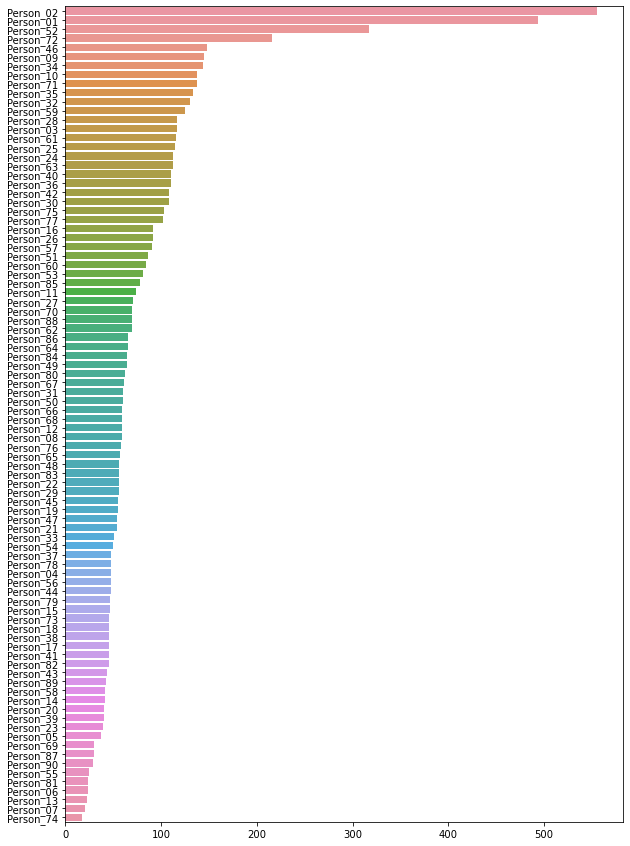

In [150]:
plt.subplots(figsize=(10, 15))
sns.barplot(y=Extracted_Features_DF['Person'].value_counts().index, x=Extracted_Features_DF['Person'].value_counts().values)

<AxesSubplot:>

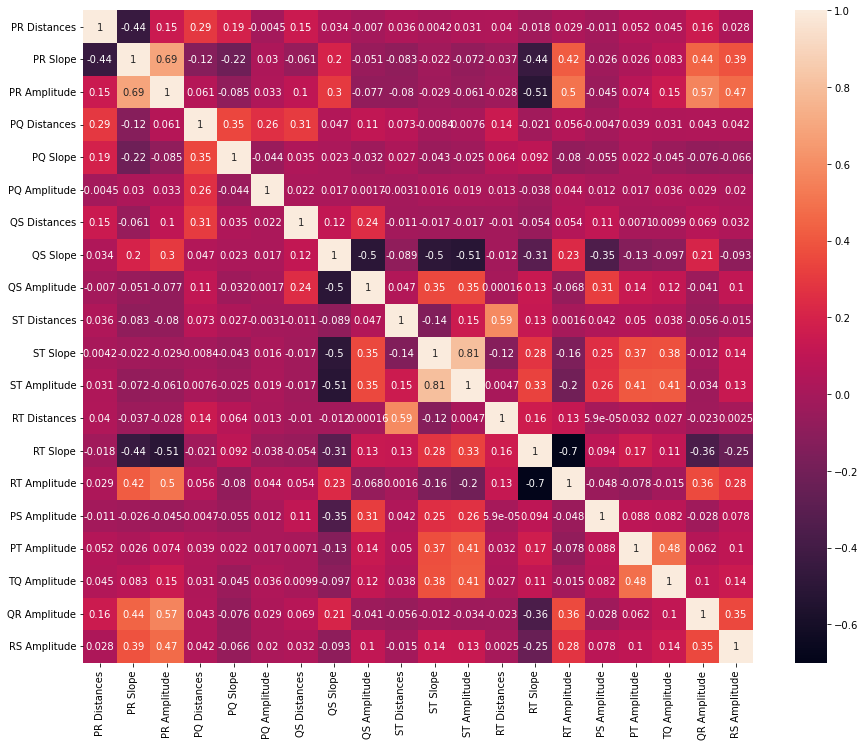

In [151]:
# correlation between features
plt.subplots(figsize=(15, 12))
sns.heatmap(Extracted_Features_DF.corr(), annot=True)

In [152]:
# split the data
df = Extracted_Features_DF.dropna()

X = Extracted_Features_DF.iloc[:, :-1]
y = Extracted_Features_DF['Person']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Traning the ML model

In [107]:
ExtraTree = ExtraTreesClassifier(n_estimators=100, criterion='entropy', verbose=2)
ExtraTree.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished


ExtraTreesClassifier(criterion='entropy', verbose=2)

In [108]:
RFT = RandomForestClassifier(n_estimators=100, criterion='entropy', verbose=2)
RFT.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.0s finished


RandomForestClassifier(criterion='entropy', verbose=2)

# Evaluation

In [109]:
# ExtraTree model
ExtraTree_preds = ExtraTree.predict(X_test)
print('accuracy_score:', accuracy_score(ExtraTree_preds, y_test.values))
print('f1_score:', f1_score(y_test.values, ExtraTree_preds, average='weighted'))
print('recall_score:', recall_score(ExtraTree_preds, y_test.values, average='weighted'))
print('precision_score:', precision_score(ExtraTree_preds, y_test.values, average='weighted'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


accuracy_score: 0.9320905459387483
f1_score: 0.9301650502528296
recall_score: 0.9320905459387483
precision_score: 0.9421500340090198


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [110]:
# Random Forest model
RFT_preds = RFT.predict(X_test)
print('accuracy_score:', accuracy_score(RFT_preds, y_test.values))
print('f1_score:', f1_score(y_test.values, RFT_preds, average='weighted'))
print('recall_score:', recall_score(RFT_preds, y_test.values, average='weighted'))
print('precision_score:', precision_score(RFT_preds, y_test.values, average='weighted'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


accuracy_score: 0.929427430093209
f1_score: 0.9275216835435502
recall_score: 0.929427430093209
precision_score: 0.9393719629806833


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [111]:
model_path = 'C:\\Users\\Steven20367691\\Desktop\\'

# Save the model
joblib.dump(ExtraTree, model_path+'RFC Model xgb 2.h5')

['C:\\Users\\Steven20367691\\Desktop\\RFC Model xgb 2.h5']

In [112]:
# load the model
ExtraTree_model = joblib.load(model_path+'RFC Model xgb 2.h5')

In [113]:
model_path = 'C:\\Users\\Steven20367691\\Desktop\\'

# Save the model
joblib.dump(RFT, model_path+'RFC Model RFT 2.h5')

['C:\\Users\\Steven20367691\\Desktop\\RFC Model RFT 2.h5']

In [114]:
# load the model
RFT_model = joblib.load(model_path+'RFC Model RFT 2.h5')